In [1]:
# Update PATH environment variable
import os
os.environ['PATH'] = '/opt/homebrew/bin:' + os.environ['PATH']

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from fppanalysis.running_moments import window_radius, run_norm_ds

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full

from velocity_estimation import two_dim_velocity_estimates as tdve
from velocity_estimation import utils as u
from  velocity_estimation import time_delay_estimation as td

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### This code plots time delay estimation (TDE) vector plots

In [2]:
cross_correlation_method = False

if cross_correlation_method:

    #-------------- Cross correlation ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CC

    use_3point_method = True
    ccf_min_lag = 1
    minimum_cc_value = 0
    running_mean = True

    eo.use_3point_method = True if use_3point_method == True else False
    eo.cc_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.cc_options.minimum_cc_value = minimum_cc_value

else:
        
    #-------------- Cross conditional average ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CA

    use_3point_method = True
    ccf_min_lag = 1
    running_mean = True
    plot_events = False
    ca_min = 2.5
    ca_max = np.inf

    eo.use_3point_method = True if use_3point_method == True else False
    eo.ca_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.ca_options.delta = 1.4e-4
    eo.ca_options.window = True
    eo.ca_options.min_threshold = ca_min
    eo.ca_options.max_threshold = ca_max

In [15]:
# shot = 1110201011
shot = 1160616018
f_GW = greenwald_fraction[shot]
path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')
R_coordinates, Z_coordinates = get_rz_full(ds)

In [16]:
# Remove dead pixels
path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
dead_pix = np.load(
    str(path_dead_pixel)
    + "/"
    + f"dead_pixels_shot_{shot}.npz"
)
dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
for y in range(dead_pix_arr_ds.shape[0]):
    for x in range(dead_pix_arr_ds.shape[1]):
        if dead_pix_arr_ds[9-y, x]:
            ds['frames'].loc[dict(y=y, x=x)] = np.nan

In [17]:
# Slice and normalize data
t_start = shot_time_window[shot][0]
t_end = shot_time_window[shot][1]
sliced_ds = ds.sel(time=slice(t_start, t_end))
radius = window_radius(1e3, sliced_ds.time)
ds = run_norm_ds(sliced_ds, radius)

In [18]:
# Estimate velocities
movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()
events = movie_data.get_events()

In [19]:
# Mark dead and alive pixels
true_indices = np.where(dead_pix_arr)
false_indices = np.where(dead_pix_arr == False)

dead_pixels_R = R[true_indices]
dead_pixles_Z = Z[true_indices]
alive_pixels_R = R[false_indices]
alive_pixels_Z = Z[false_indices]

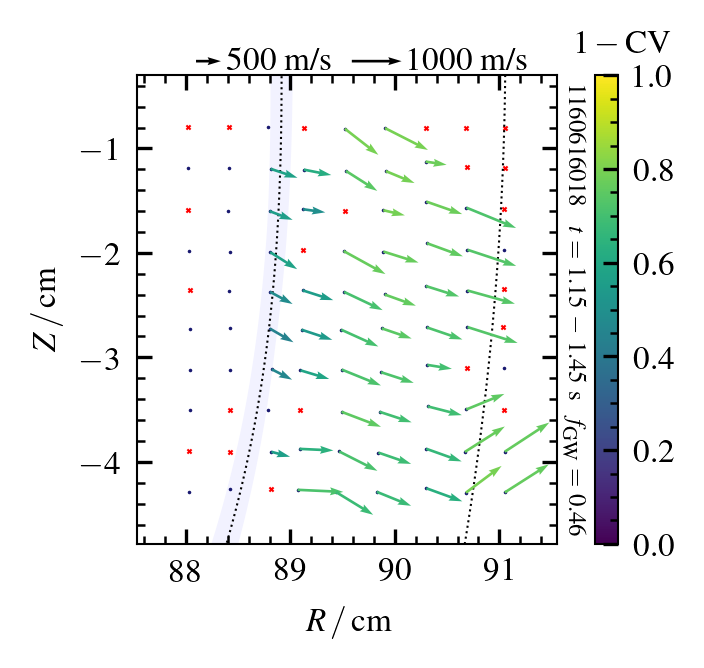

In [20]:
save = True

# axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
# plt.rcParams["mathtext.fontset"] = "custom"
# plt.rcParams["font.size"] = 6
# plt.rcParams["axes.labelsize"] = 6
# plt.rcParams["xtick.labelsize"] = 6
# plt.rcParams["ytick.labelsize"] = 6
# plt.rcParams["xtick.major.size"] = 3
# plt.rcParams["xtick.minor.size"] = 1.5
# plt.rcParams["ytick.major.size"] = 3
# plt.rcParams["ytick.minor.size"] = 1.5
# plt.rcParams["ytick.minor.width"] = 0.5
# plt.rcParams["xtick.minor.width"] = 0.5
# plt.rcParams["ytick.major.width"] = 0.5
# plt.rcParams["xtick.major.width"] = 0.5

# fig = plt.figure()
# ax = fig.add_axes(axes_size)

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')

fig, ax = plt.subplots()

# Define the default vmin and vmax values
if cross_correlation_method:
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
elif plot_events:
  default_vmin = min(events[0])
  default_vmax = max(events[0])
  default_vmax = 800
  norm = mpl.colors.Normalize(vmin=0, vmax=default_vmax)
else:
  norm = mpl.colors.Normalize(vmin=0, vmax=1)


if shot == 1160616018 or shot == 1110201016:
    # Wave mode pixels
    # Create a 10x9 array filled with False
    wave_pixels_bool = np.full((10, 9), False, dtype=bool)

    # Set two innermost columns to True
    wave_pixels_bool[:, [0, 1]] = True

    if shot == 1110201016:
        wave_pixels_bool[0, 7] = True
        wave_pixels_bool[0, 8] = True

    # Mark dead and alive pixels
    true_indices_wave = np.where(wave_pixels_bool)
    vx[true_indices_wave] = np.nan
    vy[true_indices_wave] = np.nan
    confidences[true_indices_wave] = np.nan
    wave_pixels_R = R[true_indices_wave]
    wave_pixles_Z = Z[true_indices_wave]

if shot == 1110201011:
    # Create a 10x9 array filled with False
    wave_pixels_bool = np.full((10, 9), False, dtype=bool)

    # Set the two innermost columns to True
    wave_pixels_bool[:, [0]] = True

    # Mark dead and alive pixels
    true_indices_wave = np.where(wave_pixels_bool)
    vx[true_indices_wave] = np.nan
    vy[true_indices_wave] = np.nan
    confidences[true_indices_wave] = np.nan
    wave_pixels_R = R[true_indices_wave]
    wave_pixles_Z = Z[true_indices_wave]

# Plot dead and alive pixels
ax.scatter(dead_pixels_R, dead_pixles_Z, marker='x', color='red', s=1, linewidth=0.5, zorder=1)
ax.scatter(alive_pixels_R, alive_pixels_Z, marker=".", color='midnightblue', s=0.5, zorder=1)

# # Plot LCFS and limiter
path_LCFS = Path('/Users/ahe104/box/mfe_data/LCFS_limiter')
LCFS_limiter_data = np.load(
    str(path_LCFS)
    + "/"
    + f"LCFS_limiter_{shot}.npz"
)

R_limiter = LCFS_limiter_data['R_limiter']
Z_limiter = LCFS_limiter_data['Z_limiter']
R_LCFS = LCFS_limiter_data['R_LCFS']
Z_LCFS = LCFS_limiter_data['Z_LCFS']
R_LCFS_mean = LCFS_limiter_data['R_LCFS_mean']
R_LCFS_min = LCFS_limiter_data['R_LCFS_min']
R_LCFS_max = LCFS_limiter_data['R_LCFS_max']

#R_LCFS_mean, R_LCFS_min, R_LCFS_max, Z_LCFS, R_limiter, Z_limiter = mean_LCFS(shot)
ax.plot(R_LCFS_mean, Z_LCFS, color="black", linestyle=":", linewidth=0.5)
ax.fill_betweenx(
    Z_LCFS.ravel(),
    R_LCFS_min.ravel(),
    R_LCFS_max.ravel(),
    color=(0.95, 0.95, 1.0),
    zorder=0,
)
ax.plot(R_limiter, Z_limiter, color="black", linestyle=":", linewidth=0.5)

# Plot the velocity field
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    events if plot_events else confidences,
    scale=210000,
    scale_units="xy",
    angles="xy",
    norm=norm,
    zorder=2,
)
qk = ax.quiverkey(
    qiv, 0.63, 1.03, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':8}, labelsep=0.02
)
qk = ax.quiverkey(
    qiv, 0.2, 1.03, 50000, r"$500$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':8}, labelsep=0.02
)

cbar = fig.colorbar(qiv, format="%.1f")
if cross_correlation_method:
    cbar.ax.set_ylabel(r"max $\widehat{R}_{\widetilde{{\Phi}}}$", rotation=270, labelpad=13)
elif plot_events:
  cbar.ax.text(x=-0.45, y=830, s=r'$1 - \mathrm{CV}$')
else:
  cbar.ax.text(x=-0.8, y=1.05, s=r'$1 - \mathrm{CV}$')

ax.set_xlabel(r"$R \,/\, \mathrm{cm}$")
ax.set_ylabel(r"$Z \,/\, \mathrm{cm}$")
ax.set_aspect("equal")

ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0]) + 0.5)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.5, max(R_coordinates[:, 0]) + 0.5])

plt.xticks(np.arange(round(min(R_coordinates[:, 0])), round(max(R_coordinates[:, 0]))+1, 1))
plt.yticks(np.arange(round(min(Z_coordinates[0])), round(max(Z_coordinates[0]))+1, 1))

ax.set_title(f'{shot} ~ 'r'$t = $'f' {t_start} 'r'$ - $' f' {t_end} s' r'  ~ $\mathit{f}_{\mathrm{GW}} = $' f" {f_GW}", x=1.04, y=-0.03, fontsize=6, rotation=270)

formats = ["pdf", "eps"]
foldername_shot = f'/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
if save == True:
    for fmt in formats:
        if cross_correlation_method: 
            filename =  f'tde_ccf_{shot}_min_lag_{ccf_min_lag}_min_{ca_min}_max_{ca_max}.{fmt}'
        else:
            filename =  f'tde_ca_{shot}_min_lag_{ccf_min_lag}_min_{ca_min}_max_{ca_max}_test.{fmt}'
        fig.savefig(foldername_shot + filename, bbox_inches="tight", format=fmt)

In [19]:
shotlist = [1160616018, 1110201011, 1110201016]

In [22]:
movie_data_dict = {}
dead_pixels_dict = {}
LCFS_limiter_dict = {}
R_Z_coordinates_dict = {}  

path_LCFS = Path('/Users/ahe104/box/mfe_data/LCFS_limiter')

for shot in shotlist:
    
    path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
    ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')
    R_coordinates, Z_coordinates = get_rz_full(ds)

    # Slice and normalize data
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    # Estimate velocities
    movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
    R = movie_data.get_R()
    Z = movie_data.get_Z()

    # Mark dead and alive pixels
    true_indices = np.where(dead_pix_arr)
    false_indices = np.where(dead_pix_arr == False)

    dead_pixels_R = R[true_indices]
    dead_pixles_Z = Z[true_indices]
    alive_pixels_R = R[false_indices]
    alive_pixels_Z = Z[false_indices]

    LCFS_limiter_data = np.load(
        str(path_LCFS)
        + "/"
        + f"LCFS_limiter_{shot}.npz"
    )

    movie_data_dict[shot] = movie_data
    dead_pixels_dict[shot] = {'dead_pixles_Z': dead_pixles_Z, 'dead_pixels_R': dead_pixels_R, 'alive_pixels_R': alive_pixels_R, 'alive_pixels_Z': alive_pixels_Z}
    LCFS_limiter_dict[shot] = {
        'R_LCFS': LCFS_limiter_data['R_LCFS'],
        'R_LCFS_mean': LCFS_limiter_data['R_LCFS_mean'], 
        'R_LCFS_min': LCFS_limiter_data['R_LCFS_min'], 
        'R_LCFS_max': LCFS_limiter_data['R_LCFS_max'], 
        'Z_LCFS': LCFS_limiter_data['Z_LCFS'], 
        'R_limiter': LCFS_limiter_data['R_limiter'], 
        'Z_limiter': LCFS_limiter_data['Z_limiter']
    }
    R_Z_coordinates_dict[shot] = {'R_coordinates': R_coordinates, 'Z_coordinates': Z_coordinates}


In [185]:
from typing import List, Tuple, Union
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

def figure_multiple_rows_columns(rows: int, columns: int, 
                                 labels: Union[List[str], None] = None,
                                 label_x: float = -0.28, label_y: float = 0.95,
                                 **kwargs) -> Tuple[Figure, List[Axes]]:
    """Returns a figure with axes which is appropriate for (rows, columns) subfigures.

    Parameters
    ----------
    rows : int
        The number of rows in the figure
    columns : int
        The number of columns in the figure
    labels : List[str] | None
        The labels to be applied to each subfigure. Defaults to (a), (b), (c), ...
    label_x and label_y: float
        x- and y- positions of the labels relative to each Axes object.
    **kwargs:
        Additional keyword arguments to be passed to Axes.text. 
        
    Returns
    -------
    plt.Figure
        The figure object
    List[plt.Axes]
        A list of all the axes objects owned by the figure
    """
    # fig = plt.figure(figsize = (columns*3.37, rows*2.08277))
    #fig = plt.figure(figsize = (columns*3.37, rows*2.08277))
    fig = plt.figure(figsize=(columns * 2.5, rows * 2))
    axes = []
    labels = labels or [r"$\mathrm{{({})}}$".format(chr(97+l)) for l in range(rows*columns)] 
    for r in range(rows):
        for c in range(columns):
            # left = (0.03)/columns + c/columns
            # bottom = (0.03)/rows + (rows-1-r)/rows # Start at the top
            # width = 1/columns
            # height = 1/rows
            left = (0.2)/columns + c/columns
            bottom = (0.2)/rows + (rows-1-r)/rows # Start at the top
            width = 0.75/columns
            height = 0.75/rows
            axes.append(fig.add_axes((left, bottom, width, height)))
            axes[-1].text(label_x, label_y, labels[columns*r+c], transform=axes[-1].transAxes, **kwargs)

    return fig, axes

In [182]:
def set_rcparams_dynamo_TDE(
    myParams: mpl.RcParams, num_cols: int = 1, ls: str = "thin"
) -> List[float]:
    """Half column width figures for revtex.

    See http://publishing.aip.org/authors/preparing-graphics

    Parameters
    ----------
    myParams: matplotlib.RcParams
        The parameters from matplotlib
    num_cols: int
        Number of columns the figure spans.
        1 column  = 3.37" by 2.08"
        2 columns = 6.69" by 4.13"
    ls: str
        Either 'thick' or 'thin'. Defaults to 'thin'
    fonts: str
        Either 'small' or 'large'.

    Returns
    -------
    List[float]
        The size of the axes.

    Raises
    ------
    ValueError
        If the number of columns is not 1 or 2.
    """

    golden_ratio = 0.5 * (1.0 + np.sqrt(5.0))
    fig_dpi = 300.0
    fontsize = 8

    linewidth = 0.75
    if ls == "thick":
        linewidth *= 2

    # Define axis size to be used
    if num_cols == 1:
        ax_x0, ax_y0 = 0.2, 0.2
        axes_size = [ax_x0, ax_y0, 1, 1]
    elif num_cols == 2:
        ax_x0, ax_y0 = 0.1, 0.2
        axes_size = [ax_x0, ax_y0, 0.975 - ax_x0, 0.95 - ax_y0]
    else:
        raise ValueError("num_cols must be 1 or 2")

    # Figure size in inch
    fig_width_in = num_cols * 3.37
    fig_height_in = 3.37 / golden_ratio

    # Figure size and dpi
    myParams["figure.dpi"] = fig_dpi
    myParams["figure.figsize"] = [fig_width_in, fig_height_in]
    myParams["savefig.dpi"] = fig_dpi

    # Figure legend
    myParams["legend.framealpha"] = 1.0
    myParams["legend.fancybox"] = False
    myParams["legend.edgecolor"] = "k"
    myParams["patch.linewidth"] = 0.5  # For legend box borders
    myParams["legend.handlelength"] = 1.45  # Show nice, even
    # numbers for different line styles

    # Font and text
    myParams["text.usetex"] = True
    myParams["pdf.fonttype"] = 42
    myParams["font.family"] = "Times"
    myParams["font.size"] = fontsize
    myParams["axes.labelsize"] = fontsize
    myParams["legend.fontsize"] = fontsize

    # Line size and marker size
    myParams["lines.markersize"] = 3.0 * linewidth
    myParams["lines.linewidth"] = linewidth

    # Axes thickness
    myParams["axes.linewidth"] = 0.5
    # Enable minor ticks
    myParams["ytick.minor.visible"] = True
    myParams["xtick.minor.visible"] = True
    # Default ticks on both sides of the axes
    myParams["xtick.top"] = True
    myParams["xtick.bottom"] = True
    myParams["ytick.left"] = True
    myParams["ytick.right"] = True
    # All ticks point inward
    myParams["xtick.direction"] = "in"
    myParams["ytick.direction"] = "in"

    return axes_size

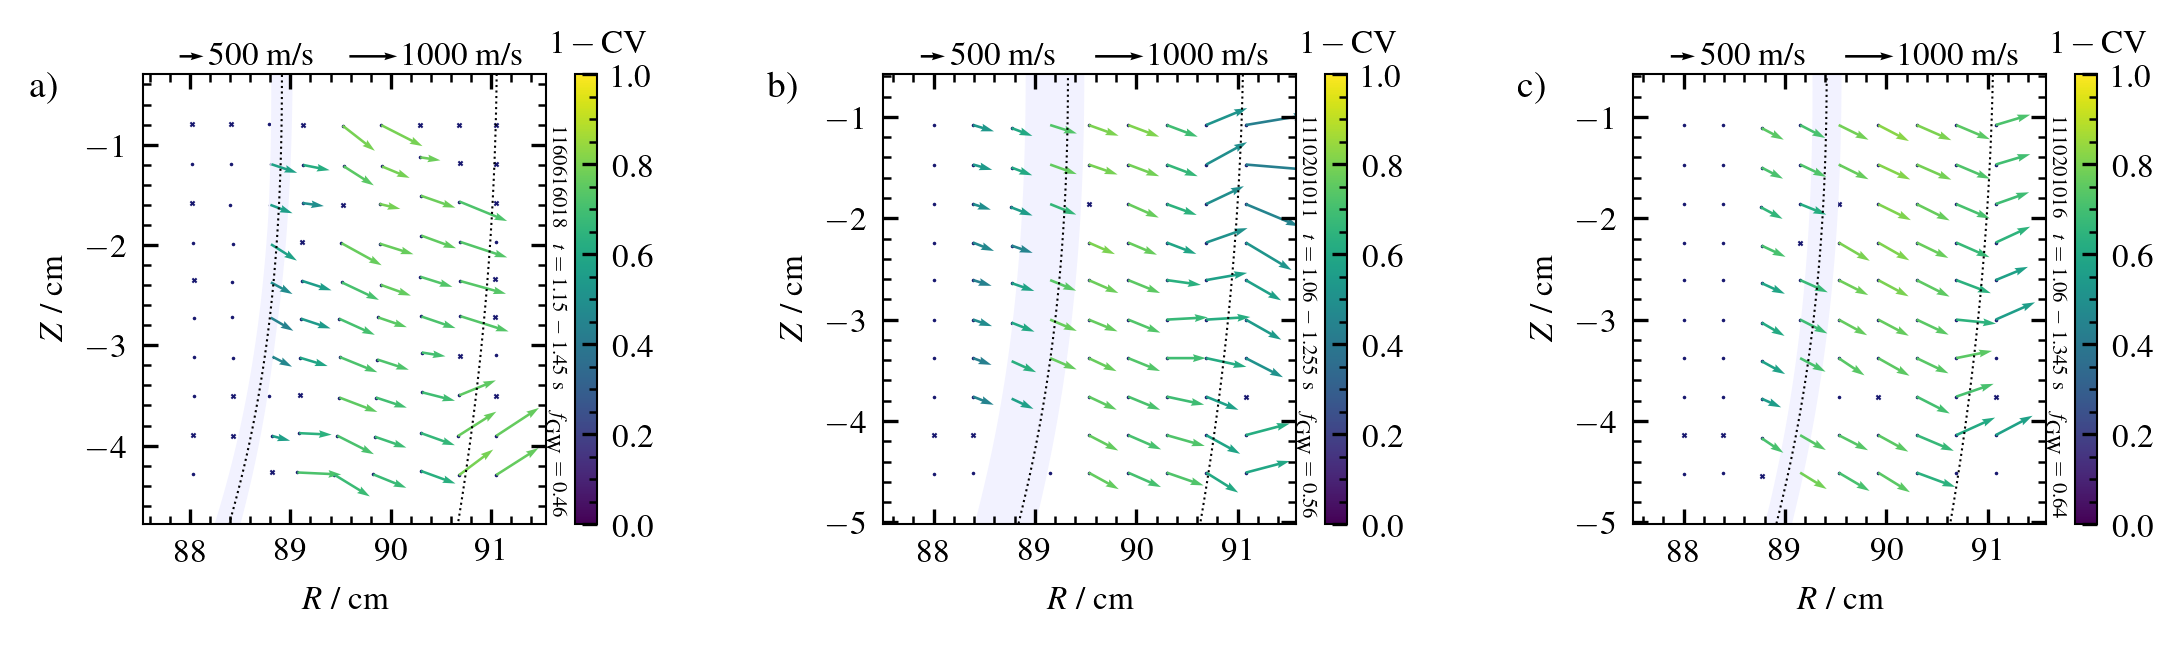

In [189]:
# Kode fra Olga! Modifisert av meg

save = True

params = {}
set_rcparams_dynamo_TDE(params, num_cols=1)
#plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')

def fixed_aspect_ratio(ratio, axes):
    '''
    Set a fixed aspect ratio on matplotlib plots
    regardless of axis units
    '''
    for ax in axes:
        xvals, yvals = ax.get_xlim(), ax.get_ylim()
        xrange = xvals[1] - xvals[0] if ax.get_xscale() == "linear" else np.log10(xvals[1]) - np.log10(xvals[0])
        yrange = yvals[1] - yvals[0] if ax.get_yscale() == "linear" else np.log10(yvals[1]) - np.log10(yvals[0])
        ax.set_aspect(ratio * (xrange / yrange))

rows = 1
columns = 3

# Use function above, not cloned from repo, to compensate for margin that cuts off when saving figure
fig, ax = figure_multiple_rows_columns(rows, columns,labels=['a)','b)','c)'],fontsize=9)

ax0=ax[0]
ax1=ax[1]
ax2=ax[2]
axs = [ax0, ax1, ax2]

ylabel_mean = r"$ \langle \Phi \rangle$"
ylabel_rel_fluct = r"$\Phi_{\mathrm{rms}} /  \langle \Phi \rangle$"
ylabel_skew = r"$S_{\Phi}$"
ylabel_flat = r"$F_{\Phi}$"
xlabel = r"$R$ / cm"
xlim = [min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15]

marker_size = 9

for idx, shot in enumerate(shotlist):
  
    f_GW = greenwald_fraction[shot]
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    R_coordinates = R_Z_coordinates_dict[shot]['R_coordinates']
    Z_coordinates = R_Z_coordinates_dict[shot]['Z_coordinates']

    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    movie_data = movie_data_dict[shot]
    dead_pixels = dead_pixels_dict[shot]
    dead_pixles_Z = dead_pixels['dead_pixles_Z']
    dead_pixels_R = dead_pixels['dead_pixels_R']
    alive_pixels_R = dead_pixels['alive_pixels_R']
    alive_pixels_Z = dead_pixels['alive_pixels_Z']

    vx = movie_data.get_vx()
    vy = movie_data.get_vy()
    confidences = movie_data.get_confidences()
    R = movie_data.get_R()
    Z = movie_data.get_Z()
    events = movie_data.get_events()

    if shot == 1160616018 or shot == 1110201016:
      # Wave mode pixels
      # Create a 10x9 array filled with False
      wave_pixels_bool = np.full((10, 9), False, dtype=bool)

      # Set two innermost columns to True
      wave_pixels_bool[:, [0, 1]] = True

      if shot == 1110201016:
          wave_pixels_bool[0, 7] = True
          wave_pixels_bool[0, 8] = True

      # Mark dead and alive pixels
      true_indices_wave = np.where(wave_pixels_bool)
      vx[true_indices_wave] = np.nan
      vy[true_indices_wave] = np.nan
      confidences[true_indices_wave] = np.nan
      wave_pixels_R = R[true_indices_wave]
      wave_pixles_Z = Z[true_indices_wave]

    if shot == 1110201011:
      # Create a 10x9 array filled with False
      wave_pixels_bool = np.full((10, 9), False, dtype=bool)

      # Set the two innermost columns to True
      wave_pixels_bool[:, [0]] = True

      # Mark dead and alive pixels
      true_indices_wave = np.where(wave_pixels_bool)
      vx[true_indices_wave] = np.nan
      vy[true_indices_wave] = np.nan
      confidences[true_indices_wave] = np.nan
      wave_pixels_R = R[true_indices_wave]
      wave_pixles_Z = Z[true_indices_wave]

    # Plot dead and alive pixels
    axs[idx].scatter(dead_pixels_R, dead_pixles_Z, marker='x', color='midnightblue', s=1, linewidth=0.5)
    axs[idx].scatter(alive_pixels_R, alive_pixels_Z, marker=".", color='midnightblue', s=0.5)

    # Plot LCFS and limiter
    LCFS_limiter_data = LCFS_limiter_dict[shot]
    R_limiter = LCFS_limiter_data['R_limiter']
    Z_limiter = LCFS_limiter_data['Z_limiter']
    R_LCFS = LCFS_limiter_data['R_LCFS']
    Z_LCFS = LCFS_limiter_data['Z_LCFS']
    R_LCFS_mean = LCFS_limiter_data['R_LCFS_mean']
    R_LCFS_min = LCFS_limiter_data['R_LCFS_min']
    R_LCFS_max = LCFS_limiter_data['R_LCFS_max']

    axs[idx].plot(R_LCFS_mean, Z_LCFS, color="black", linestyle=":", linewidth=0.5)
    axs[idx].fill_betweenx(
        Z_LCFS.ravel(),
        R_LCFS_min.ravel(),
        R_LCFS_max.ravel(),
        color=(0.95, 0.95, 1.0),
    )
    axs[idx].plot(R_limiter, Z_limiter, color="black", linestyle=":", linewidth=0.5)

    # Plot the velocity field
    qiv = axs[idx].quiver(
        R,
        Z,
        vx,
        vy,
        events if plot_events else confidences,
        scale=210000,
        scale_units="xy",
        angles="xy",
        norm=norm,
    )
    qk = axs[idx].quiverkey(
        qiv, 0.63, 1.04, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':8}, labelsep=0.02
    )
    qk = axs[idx].quiverkey(
        qiv, 0.15, 1.04, 50000, r"$500$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':8}, labelsep=0.02
    )

    cbar = fig.colorbar(qiv, format="%.1f")
    if cross_correlation_method:
        cbar.axs[idx].set_ylabel(r"max $\widehat{R}_{\widetilde{{\Phi}}}$", rotation=270, labelpad=13)
    elif plot_events:
      cbar.ax.text(x=-0.3, y=830, s=r'$1 - \mathrm{CV}$')
    else:
      cbar.ax.text(x=-1, y=1.05, s=r'$1 - \mathrm{CV}$')

    axs[idx].set_xlabel(r"$R$ / cm")
    axs[idx].set_ylabel(r"$Z$ / cm")
    #axs[idx].set_aspect("equal")

    axs[idx].set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0]) + 0.5)
    axs[idx].set_xlim([min(R_coordinates[:, 0]) - 0.5, max(R_coordinates[:, 0]) + 0.5])

    axs[idx].set_title(f'{shot} ~~'r'$t = $'f' {t_start} 'r'$ - $' f' {t_end} s' r'  ~~ $f_{\mathrm{GW}} = $' f" {f_GW}", x=1.025, y=-0.03, fontsize=5, rotation=270)

    axs[idx].set_aspect("equal")
    
    axs[idx].set_xticks(np.arange(round(min(R_coordinates[:, 0])), round(max(R_coordinates[:, 0]))+1, 1))
    axs[idx].set_yticks(np.arange(round(min(Z_coordinates[0])), round(max(Z_coordinates[0]))+1, 1))

# plt.xticks(np.arange(round(min(R_coordinates[:, 0])), round(max(R_coordinates[:, 0]))+1, 1))
# plt.yticks(np.arange(round(min(Z_coordinates[0])), round(max(Z_coordinates[0]))+1, 1))

# fixed_aspect_ratio(1, [ax0, ax1, ax2])
  

# plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.7)  # Adjust margins if needed

if save == True:
  formats = ["pdf", "eps"]
  foldername = "/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/"
  for fmt in formats:
    filename = f"TDEs.{fmt}"
    fig.savefig(foldername + filename, format=fmt)#, bbox_inches="tight")